# Question 7

## Extract tweets from given data file

In [13]:
import json

rel_path = "twitter_data/"
fh = open(rel_path+'tweets_#gopatriots.txt', 'rt',encoding = 'UTF-8')
text = fh.readlines()
fh.close()
with open(rel_path+'cleaned_gopatriots.txt', 'w') as f:
    for line in text:
        deserialized = json.loads(line)
        if deserialized['tweet']['lang'] == "en":
        #print deserialized['tweet']['text']
            #print deserialized['tweet']['text'].encode('utf8')
            f.write(str(deserialized['tweet']['text'].encode('utf8')))
            f.write('\n')


## Generate Tweets

In [29]:
import numpy as np
from nltk.corpus import words
rel_path = "twitter_data/"
dictionary = set(words.words())
other_tag_set =set (["#superbowl" , '#sb49', "#patriots",'#nfl','#gohawks'])
# data I/O
data = open(rel_path+'cleaned_gopatriots.txt', 'rt',encoding='UTF-8').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
    """
    sample a sequence of integers from the model
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
hash_count = np.zeros(1005)
eng_word_count = np.zeros(1005)
other_tags_count = np.zeros(1005)

while (n <= 100500):
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))
        hash_in_tweets = [i  for i in txt.split() if i.startswith("#") ]
        hash_count[n/100 - 1] = len(hash_in_tweets)                      #number of hastags in tweet
        eng_words = [i  for i in txt.split() if (i in dictionary) ]
        eng_word_count[n/100 - 1] = len(eng_words)                       #number of valid english words in tweet
        other_tags =[i  for i in txt.split() if (i.startswith("#") and i.lower() in other_tag_set) ]
        other_tags_count[n/100 - 1] = len(other_tags)                               #number of hashtags other than #gopatriots 
        
    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 100 == 0: print ('iter %d, loss: %f' % (n, smooth_loss) )# print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],[dWxh, dWhh, dWhy, dbh, dby],[mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter


data has 1318792 characters, 95 unique.
----
 'GjuJ=%zn#4ytTiCl@j~gg!Q`)yu[MffACc$ApgfU@+pQsY79}o7GmQ2a+`8M-4"kfN{'1vlh)
c`!Rc|mbMi-KC&u~UD_y2qhr$5v,werT9V~{kX*GYNqkJ=Nv,E"4V-yFW}l878LoC!6mrm"}g nO%sprWrg=Ij_sM`r!,Ku@
voB/l/"x.
}2E'g<2Ujxi5(NNGV} 
----
iter 0, loss: 113.846925


C:\Users\cmuth\Anaconda3\lib\site-packages\ipykernel\__main__.py:102: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cmuth\Anaconda3\lib\site-packages\ipykernel\__main__.py:104: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cmuth\Anaconda3\lib\site-packages\ipykernel\__main__.py:106: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


----
 ao  oesS' me#eawakt a aeteby oye# tntteWnl   aae sn d
#sse  vw mtoas ysey  e ei a
 sly lae o  n e s_aven i   aeyahtetmnwae  aeatnxoeea'eewamsmlea ev sa  aa eatonaaowHaW aey 
neoy  aaetsnev eallay ee@n 
----
iter 100, loss: 116.067016
----
 iPocOokiU iod#9upp#pstafh
9ot PahNpocad'upsPyooWnrpdc inb\pria 's' pahoacix@@.n/ec/iih "chcoewMc@ocumo!d#uep wo;h keuGiotuRicpaohh\R itiRcoco\ /gsNowiay.OiuiOaoWoinoo#uu:cook hdt owi:gtgwh hhri iRoo . 
----
iter 200, loss: 114.204332
----
 okriS   f2rob  ,w-r iat@ i B r o s.'PieorbsBm
me es ,  oa 
Brrrws #riohwow o tPsKRr sn oPftOe wesio sn a l  wwr3of9 svfH#/@@oibt'ioP.t
biob w s w  e9g o'iireg mg"g:Nr Bg ok.h  
 iekrs3 iw#Bes sr'QGoYG 
----
iter 300, loss: 111.927498
----
 lisla p y  S  y oPht ephe Ep l ?p NF y 8eiie 5!cPat cntf!Sm e p lrstbnn  Lee ho  a.c #t  d Kpd?  ape jnoy n:y onHz0a DCwR W'
y8ur WnS?rocd eugotrdn@y?mhs md t Una"hr tongtSayge yf1 e gdt y v dye un 1n 
----
iter 400, loss: 109.516423
----
 ge #nt e#kie ih/ sd ne #rato-saeeh

## Nmber of hashtags Vs iterations

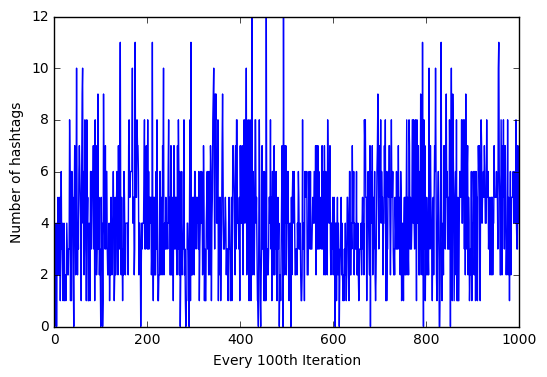

In [30]:
import matplotlib.pyplot as plt
plt.plot(hash_count[:1000])
plt.xlabel("Every 100th Iteration")
plt.ylabel("hashtags count")
plt.show()


## Number of English words vs Iteration Count

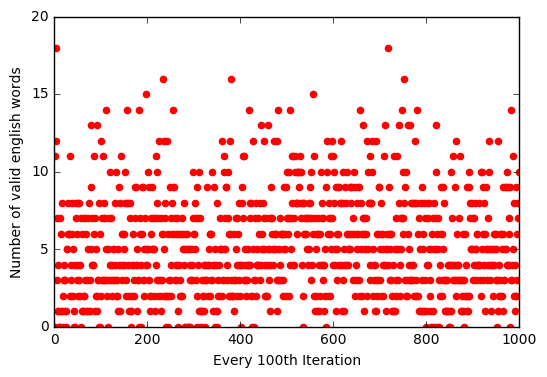

In [45]:

plt.scatter(range(1,1001),eng_word_count[:1000],color = 'r')
plt.xlabel("Every 100th Iteration")
plt.ylabel("Number of valid english words")
plt.ylim(ymin=0)
plt.xlim(xmin=0,xmax = 1000)
plt.show()


## Number of other tags vs iteration count

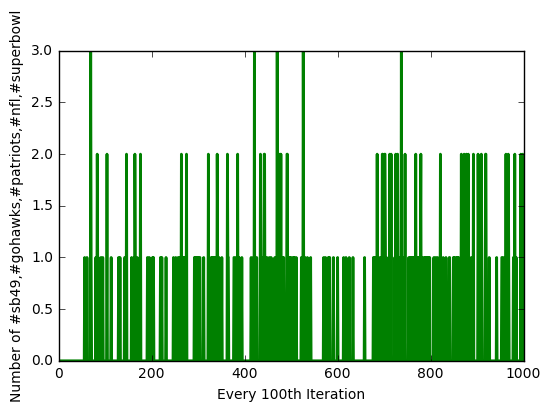

In [46]:

plt.plot(range(1,1001),(other_tags_count[:1000]),linewidth = 2,color = 'g')
plt.xlabel("Every 100th Iteration")
plt.ylabel("Number of #sb49,#gohawks,#patriots,#nfl,#superbowl")
plt.ylim(ymin=0)
plt.xlim(xmin=0,xmax = 1000)
plt.show()
